In [1]:
import numpy as np
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
def load_images_from_folder(folder, img_size):
    images = []
    labels = []
    classes = os.listdir(folder)
    print(f"Classes found: {classes}")
    for label, class_name in enumerate(classes):
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            continue
        print(f"Processing class: {class_name}")
        img_files = glob.glob(os.path.join(class_path, '*.png'))
        print(f"Found {len(img_files)} images in {class_name}")
        for img_path in img_files:
            print(f"Found image: {img_path}")
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
                print(f"Loaded image: {img_path}, label: {label}")
            else:
                print(f"Failed to load image: {img_path}")
    return np.array(images), np.array(labels)

In [3]:
base_folder = os.getcwd()  # Get the current working directory
train_folder = os.path.join(base_folder, 'synthetic_galaxy_images', 'train')
test_folder = os.path.join(base_folder, 'synthetic_galaxy_images', 'test')
img_size = (64, 64)

X_train, y_train = load_images_from_folder(train_folder, img_size)
X_test, y_test = load_images_from_folder(test_folder, img_size)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of training labels: {y_train.shape[0]}')
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'Number of testing labels: {y_test.shape[0]}')

if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    print("No images found in the specified directories. Please check the file paths and directory structure.")

X_train = X_train / 255.0
X_test = X_test / 255.0

encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

Classes found: ['elliptical', 'irregular', 'spiral']
Processing class: elliptical
Found 2666 images in elliptical
Found image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_1.png
Loaded image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_1.png, label: 0
Found image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_100.png
Loaded image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_100.png, label: 0
Found image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_1000.png
Loaded image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_1000.png, label: 0
Found image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_1001.png
Loaded image: c:\Users\Aseem\Desktop\BE Project\synthetic_galaxy_images\train\elliptical\galaxy_1001.png, label: 0
Found image: c:\Us

In [21]:
class SimpleCNN:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.initialize_weights()

    def initialize_weights(self):
        np.random.seed(42)
        self.W1 = np.random.randn(3, 3, 3, 16).astype(np.float64) * 0.1
        self.b1 = np.zeros((16,), dtype=np.float64)
        self.W2 = np.random.randn(3, 3, 16, 32).astype(np.float64) * 0.1
        self.b2 = np.zeros((32,), dtype=np.float64)
        self.W3 = np.random.randn(32 * 16 * 16, 128).astype(np.float64) * 0.1
        self.b3 = np.zeros((128,), dtype=np.float64)
        self.W4 = np.random.randn(128, self.num_classes).astype(np.float64) * 0.1
        self.b4 = np.zeros((self.num_classes,), dtype=np.float64)

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / expZ.sum(axis=1, keepdims=True)

    def max_pool(self, A, pool_size=2, stride=2):
        n, h, w, c = A.shape
        h_out = (h - pool_size) // stride + 1
        w_out = (w - pool_size) // stride + 1
        
        output = np.zeros((n, h_out, w_out, c))
        self.max_pool_masks = {}  
        
        for i in range(h_out):
            for j in range(w_out):
                h_start = i * stride
                h_end = h_start + pool_size
                w_start = j * stride
                w_end = w_start + pool_size
                
                window = A[:, h_start:h_end, w_start:w_end, :]
                
                window_reshaped = window.reshape(n, -1, c)
                max_indices = window_reshaped.argmax(axis=1)

                mask = np.zeros_like(window)
                for batch in range(n):
                    for channel in range(c):
                        idx = max_indices[batch, channel]
                        h_idx, w_idx = np.unravel_index(idx, (pool_size, pool_size))
                        mask[batch, h_idx, w_idx, channel] = 1

                self.max_pool_masks[(i, j)] = mask

                output[:, i, j, :] = window_reshaped.max(axis=1)
        
        return output

    def max_pool_backward(self, dout, pool_size=2, stride=2):
        print("max_pool_backward input shape:", dout.shape)
        n, h, w, c = dout.shape
        h_out = h * stride
        w_out = w * stride
        dx = np.zeros((n, h_out, w_out, c))
        
        for i in range(h):
            for j in range(w):
                h_start = i * stride
                h_end = h_start + pool_size
                w_start = j * stride
                w_end = w_start + pool_size

                mask = self.max_pool_masks.get((i, j))
                if mask is None:
                    continue

                if mask.shape[-1] != dout.shape[-1]:
                    new_mask = np.zeros((n, pool_size, pool_size, dout.shape[-1]))
                    min_channels = min(mask.shape[-1], dout.shape[-1])
                    new_mask[..., :min_channels] = mask[..., :min_channels]
                    mask = new_mask

                dx[:, h_start:h_end, w_start:w_end, :] += mask * dout[:, i:i+1, j:j+1, :].reshape(n, 1, 1, -1)
        
        return dx

    def forward(self, X):
        X = X.astype(np.float64)
        
        self.Z1 = np.zeros((X.shape[0], 64, 64, 16), dtype=np.float64)
        for i in range(X.shape[0]):
            for k in range(self.W1.shape[3]):
                conv_result = np.zeros((64, 64), dtype=np.float64)
                for c in range(3):
                    kernel = self.W1[:, :, c, k]
                    conv_result += cv2.filter2D(X[i, :, :, c], -1, kernel)
                self.Z1[i, :, :, k] = conv_result
        self.Z1 += self.b1
        self.A1 = self.relu(self.Z1)
        self.P1 = self.max_pool(self.A1)
        
        self.Z2 = np.zeros((self.P1.shape[0], 32, 32, 32), dtype=np.float64)
        for i in range(self.P1.shape[0]):
            for k in range(self.W2.shape[3]):
                conv_result = np.zeros((32, 32), dtype=np.float64)
                for c in range(16):
                    kernel = self.W2[:, :, c, k]
                    conv_result += cv2.filter2D(self.P1[i, :, :, c], -1, kernel)
                self.Z2[i, :, :, k] = conv_result
        self.Z2 += self.b2
        self.A2 = self.relu(self.Z2)
        self.P2 = self.max_pool(self.A2)
        
        self.F = self.P2.reshape(X.shape[0], -1)
        self.Z3 = np.dot(self.F, self.W3) + self.b3
        self.A3 = self.relu(self.Z3)
        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.A4 = self.softmax(self.Z4)
        
        return self.A4

    def conv2d_backward(self, input_data, kernel_size, output_gradient):
        print("Input data shape:", input_data.shape)
        print("Kernel size:", kernel_size)
        print("Output gradient shape:", output_gradient.shape)
    
        input_gradient = np.zeros_like(input_data)
        kernel_gradient = np.zeros(kernel_size)
        pad_size = (kernel_size[0] - 1) // 2
        print("Pad size:", pad_size)
    
        padded_input = np.pad(input_data, 
                         ((0, 0), (pad_size, pad_size), 
                          (pad_size, pad_size), (0, 0)), 
                         mode='constant')
    
        print("Padded input shape:", padded_input.shape)

        for i in range(input_data.shape[0]):
            for c_out in range(output_gradient.shape[-1]):
                for c_in in range(input_data.shape[-1]):
                    kernel = np.flip(np.flip(self.W2[:, :, c_in, c_out], axis=0), axis=1)
                    input_gradient[i, :, :, c_in] += cv2.filter2D(
                        output_gradient[i, :, :, c_out].astype(np.float32),
                        -1, 
                        kernel.astype(np.float32),
                        borderType=cv2.BORDER_CONSTANT
                    )
    
        for i in range(input_data.shape[0]):
            for c_out in range(output_gradient.shape[-1]):
                for c_in in range(input_data.shape[-1]):
                    for h in range(kernel_size[0]):
                        for w in range(kernel_size[1]):
                            kernel_gradient[h, w, c_in, c_out] += np.sum(
                                padded_input[i, h:h+output_gradient.shape[1], w:w+output_gradient.shape[2], c_in] *
                                output_gradient[i, :, :, c_out]
                            )
    
        return input_gradient, kernel_gradient
    

    def backward(self, X, Y, learning_rate):
        m = X.shape[0]

        print("Forward pass shapes:")
        print("P2 shape:", self.P2.shape)
        print("A2 shape:", self.A2.shape)
        print("P1 shape:", self.P1.shape)

        dZ4 = self.A4 - Y
        dW4 = np.dot(self.A3.T, dZ4) / m
        db4 = np.sum(dZ4, axis=0) / m

        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * (self.A3 > 0)
        dW3 = np.dot(self.F.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0) / m
        dF = np.dot(dZ3, self.W3.T).reshape(self.P2.shape)
        dP2 = dF
        dA2 = self.max_pool_backward(dP2)
        dZ2 = dA2 * (self.A2 > 0)
        
        print("Backward pass shapes:")
        print("dP2 shape:", dP2.shape)
        print("dA2 shape:", dA2.shape)
        print("dZ2 shape:", dZ2.shape)
        
        dP1, dW2 = self.conv2d_backward(self.P1, self.W2.shape, dZ2)
        db2 = np.sum(dZ2, axis=(0, 1, 2)) / m
        
        dA1 = self.max_pool_backward(dP1)
        dZ1 = dA1 * (self.A1 > 0)
        
        _, dW1 = self.conv2d_backward(X, self.W1.shape, dZ1)
        db1 = np.sum(dZ1, axis=(0, 1, 2)) / m

        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W4 -= learning_rate * dW4
        self.b4 -= learning_rate * db4

    def train(self, X, Y, epochs, learning_rate):
        print("Training data shapes:")
        print("X shape:", X.shape)
        print("Y shape:", Y.shape)
        for epoch in range(epochs):
            Y_pred = self.forward(X)
            loss = -np.mean(np.sum(Y * np.log(Y_pred + 1e-8), axis=1))
            print(f"Epoch {epoch + 1}, Loss: {loss}")
            self.backward(X, Y, learning_rate)

    def evaluate(self, X, Y_true):
        Y_pred = self.forward(X)
        y_pred_classes = np.argmax(Y_pred, axis=1)
        y_true_classes = np.argmax(Y_true, axis=1)
        print(classification_report(y_true_classes, y_pred_classes))


In [ ]:
num_samples = 100
indices = np.random.choice(X_train.shape[0], num_samples, replace=False)
X_train_small = X_train[indices]
y_train_small = y_train[indices]
print("X_train_small shape:", X_train_small.shape)
print("y_train_small shape:", y_train_small.shape)

cnn = SimpleCNN(input_shape=(64, 64, 3), num_classes=3)
cnn.train(X_train_small, y_train_small, epochs=10, learning_rate=0.001)

X_train_small shape: (100, 64, 64, 3)
y_train_small shape: (100, 3)
Training data shapes:
X shape: (100, 64, 64, 3)
Y shape: (100, 3)
Epoch 1, Loss: 1.338451741907661
Forward pass shapes:
P2 shape: (100, 16, 16, 32)
A2 shape: (100, 32, 32, 32)
P1 shape: (100, 32, 32, 16)
max_pool_backward input shape: (100, 16, 16, 32)
Backward pass shapes:
dP2 shape: (100, 16, 16, 32)
dA2 shape: (100, 32, 32, 32)
dZ2 shape: (100, 32, 32, 32)
Input data shape: (100, 32, 32, 16)
Kernel size: (3, 3, 16, 32)
Output gradient shape: (100, 32, 32, 32)
Pad size: 1
Padded input shape: (100, 34, 34, 16)
max_pool_backward input shape: (100, 32, 32, 16)
Input data shape: (100, 64, 64, 3)
Kernel size: (3, 3, 3, 16)
Output gradient shape: (100, 64, 64, 16)
Pad size: 1
Padded input shape: (100, 66, 66, 3)
Epoch 2, Loss: 0.7325140195027261
Forward pass shapes:
P2 shape: (100, 16, 16, 32)
A2 shape: (100, 32, 32, 32)
P1 shape: (100, 32, 32, 16)
max_pool_backward input shape: (100, 16, 16, 32)
Backward pass shapes:
dP2 

Model Accuracy: 100.00%


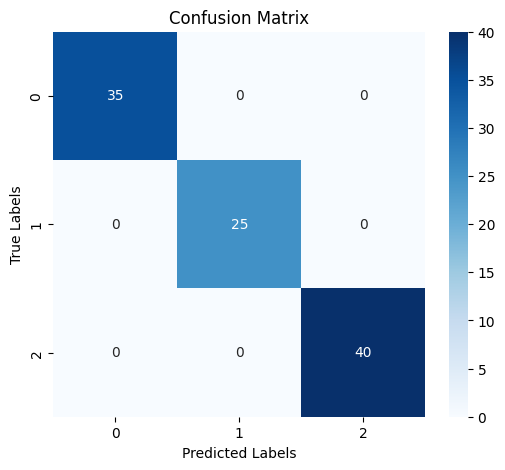

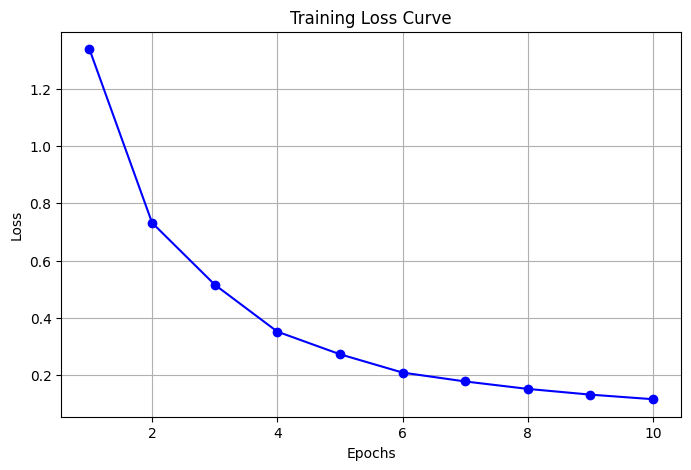

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate on training data
Y_pred = cnn.forward(X_train_small)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true_classes = np.argmax(y_train_small, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot Training Loss Curve
epochs = range(1, 11)  # Assuming 10 epochs
losses = [1.338, 0.732, 0.516, 0.352, 0.273, 0.209, 0.178, 0.152, 0.132, 0.116]  # Taken from your output

plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

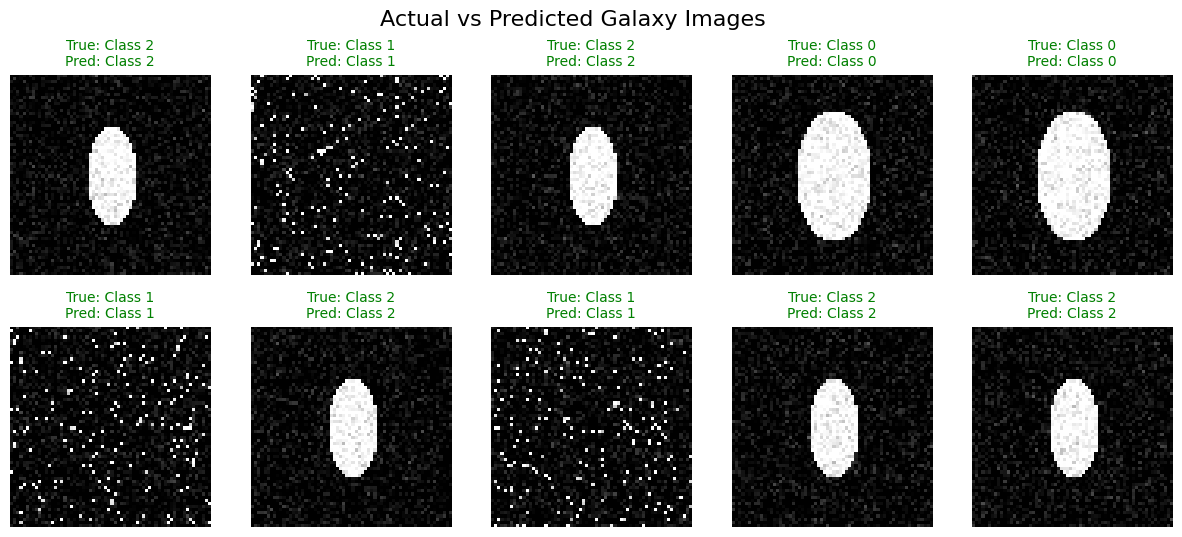

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define class labels (change if needed)
class_labels = ["Class 0", "Class 1", "Class 2"]

# Select random samples to visualize
num_samples = 10  # Number of images to display
random_indices = random.sample(range(X_train_small.shape[0]), num_samples)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    img = X_train_small[idx]  # Get the image
    true_class = np.argmax(y_train_small[idx])  # True class
    predicted_class = np.argmax(Y_pred[idx])  # Predicted class

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {class_labels[true_class]}\nPred: {class_labels[predicted_class]}",
              fontsize=10, color="green" if true_class == predicted_class else "red")

plt.suptitle("Actual vs Predicted Galaxy Images", fontsize=16)
plt.show()